In [11]:
# import JAX to use
import jax
import jax.numpy as jnp
from jax import grad, vmap, random
from sklearn.datasets import fetch_openml
import pickle
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

1. Implement a dense feedforward neural network from scratch.

   The implementation must be flexible with respect to:
   - The input and output dimensions.
   - The number of hidden layers.
   - The number of neurons per hidden layer.
   - The activation functions used.

   This implementation will be used for the following two questions.

   Choose a suitable initialization for the network parameters.

In [12]:
# We start with a function that initializes the network parameters.
def init_net_params(layer_widths, key):
    """
    Initialize the network parameters.
    layer_widths: list of integers, the number of neurons in each layer
    key: jax.random.PRNGKey, the random key
    returns: list of jax.numpy.ndarray, the network parameters
    """
    params = []
    keys = random.split(key, len(layer_widths) - 1)

    for i, (n_in, n_out) in enumerate(zip(layer_widths[:-1], layer_widths[1:])):
        w_key = keys[i]
        scale = jnp.sqrt(2.0 / n_in) # xavier initialization
        w = random.normal(w_key, shape=(n_in, n_out)) * scale
        b = jnp.zeros((n_out,))
        params.append({'w': w, 'b': b})

    return params


In [13]:
# Next, we define a forward pass function that computes the output of the network for a given input.
def forward(params, x, activation):
    """
    Forward pass of the network.
    """

    # dictionary of activation functions
    activations = {
        'relu': jax.nn.relu,
        'sigmoid': jax.nn.sigmoid,
        'tanh': jax.nn.tanh,
        'softmax': jax.nn.softmax
    }
    activation = activations[activation]

    for layer in params[:-1]:
        x = x @ layer['w'] + layer['b']
        x = activation(x)

    # output layer
    final_layer = params[-1]
    return jnp.dot(x, final_layer['w']) + final_layer['b']

def get_batches(x, y, batch_size=256):
    """
    Returns a list of tuples (x_batch, y_batch), each of size batch_size
    (last batch may be smaller).
    """
    n = x.shape[0]
    
    # Use provided key or create a new one
    key = random.PRNGKey(0)
    perm = jax.random.permutation(key, n)
    x_shuffled = x[perm]
    y_shuffled = y[perm]

    batches = []
    for i in range(0, n, batch_size):
        x_batch = x_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]
        batches.append((x_batch, y_batch))

    return batches

def get_splits(x, y, train=0.8):
    """
    This return a jax array of the training, validation, and test splits
    """
    n = x.shape[0]
    x = jnp.array(x) / 255.0 # normalize to [0,1]
    y = jnp.array(y)
    # Calculate split indices (as integers)
    train_end = int(train * n)
    test_end = train_end + int((1-train)) * n
    
    # Split the data
    x_train = x[:train_end]
    y_train = y[:train_end]
    
    x_test = x[test_end:]
    y_test = y[test_end:]
    
    return x_train, y_train, x_test, y_test

def get_kfolds(x, y, k=5):
    """
    Generate k-fold cross-validation splits.
    """
    n = x.shape[0]

    fold_size = n // k
    folds = []

    for i in range(k):
        # Validation fold indices
        val_start = i * fold_size
        val_end = (i + 1) * fold_size if i < k - 1 else n
        
        # Validation set
        x_val = x[val_start:val_end]
        y_val = y[val_start:val_end]
        
        # Training set (everything except validation fold)
        x_train = jnp.concatenate([x[:val_start], x[val_end:]], axis=0)
        y_train = jnp.concatenate([y[:val_start], y[val_end:]], axis=0)
        
        folds.append((x_train, y_train, x_val, y_val))
    
    return folds

In [14]:
# Next, we define the MSE loss function, we can have other loss functions
def mse_loss(params, x, y, activation):
    """
    MSE loss function for the network.
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    preds = batched_forward(params, x, activation)
    return jnp.mean((preds - y) ** 2)

def class_loss(params, x, y, activation):
    """
    Classification cross-entroy loss function
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    logits = batched_forward(params, x, activation)

    log_probs = jax.nn.log_softmax(logits, axis=1)
    
    nll = -log_probs[jnp.arange(y.shape[0]), y]
    loss = jnp.mean(nll)

    return loss

def evaluate_model(params, x, y, activation, classification):
    """
    Evaluate model on a dataset and return accuracy and loss.
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    logits = batched_forward(params, x, activation)

    if classification:
        preds = jnp.argmax(logits, axis=1)
        
        accuracy = jnp.mean(preds == y)
        loss = class_loss(params, x, y, activation)
        
        return accuracy, loss
    else:
        return jnp.mean((logits - y) ** 2)

In [15]:
# We now define an update function that updates the network parameters.
def update(params, x, y, activation, lr, classification):
    """
    Update function for the network parameters (basic gradient descent).
    """
    loss_fn = class_loss if classification else mse_loss
    grads = grad(loss_fn)(params, x, y, activation)
    new_params = jax.tree.map(lambda p, g: p - lr * g, params, grads)
    return new_params

# After training, save the parameters
def save_params(params, filename='assets/params.pkl'):
    """Save model parameters."""
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, 'wb') as f:
        pickle.dump(params, f)
    print(f"Parameters saved to {filename}")

def load_params(filename='assets/params.pkl'):
    """Load model parameters."""
    with open(filename, 'rb') as f:
        params = pickle.load(f)
    print(f"Parameters loaded from {filename}")
    return params

2. Consider a standard benchmark dataset for classification: train a neural network to classify handwritten digits into the ten classes 0, 1,..., 9. As input for your model, use flattened vector representations of the MNIST images^1

   (a) For this multiclass classification task, train your neural network with cross-entropy loss and mini-batch gradient descent. Vary the neural network architecture (layers, neurons per layer, activation functions) and training hyperparameters (learning rate, batch size, epochs). Use grid search with k-fold cross-validation (e.g., k = 5) to select promising hyperparameters. Report the accuracy and learning curves for the best model.

In [16]:
mnist = fetch_openml('mnist_784')
print(f"We have {mnist.data.shape[0]} images")
print(f"Each image has {mnist.data.shape[1]} pixels (features)")

We have 70000 images
Each image has 784 pixels (features)


In [17]:
def train_model_kfold(x_train, y_train, layer_widths, activation, lr, batch_size, epochs, k=5):
    """
    Train the model using kfold cross-validation.
    """
    folds = get_kfolds(x_train, y_train, k=k)
    fold_results =[]
    learning_curves = []

    for fold_idx, (x_train_fold, y_train_fold, x_val_fold, y_val_fold) in enumerate(folds):
        key = random.PRNGKey(42 + fold_idx) # we use a different key for each fold
        params = init_net_params(layer_widths, key)

        fold_history = {
            'train_acc': [],
            'val_acc': [],
            'train_loss': [],
            'val_loss': []
        }

        for epoch in range(epochs):
            batches = get_batches(x_train_fold, y_train_fold, batch_size=batch_size)

            for x_batch, y_batch in batches:
                params = update(params, x_batch, y_batch, activation, lr, classification=True)
            
            train_acc, train_loss = evaluate_model(params, x_train_fold, y_train_fold, activation, classification=True)
            val_acc, val_loss = evaluate_model(params, x_val_fold, y_val_fold, activation, classification=True)

            fold_history['train_acc'].append(float(train_acc))
            fold_history['val_acc'].append(float(val_acc))
            fold_history['train_loss'].append(float(train_loss))
            fold_history['val_loss'].append(float(val_loss))
            
            if epoch % 50 == 0:
                print(f"Fold {fold_idx+1}, Epoch {epoch}: Val Acc = {val_acc:.4f}, Val Loss = {val_loss:.4f}")
        
        final_train_acc, final_train_loss = evaluate_model(params, x_train_fold, y_train_fold, activation, classification=True)
        final_val_acc, final_val_loss = evaluate_model(params, x_val_fold, y_val_fold, activation, classification=True)

        fold_results.append((final_train_acc, final_val_acc, final_train_loss, final_val_loss))
        learning_curves.append(fold_history)
    
    mean_val_acc = np.mean([fold[1] for fold in fold_results])
    mean_val_loss = np.mean([fold[3] for fold in fold_results])
    
    return mean_val_acc, mean_val_loss, fold_results, learning_curves

def train_model(x_train, y_train, x_test, y_test, best_config):
    """
    Train the best model on the full training set and evaluate on test set.
    """
    layer_widths = best_config['layer_widths']
    activation = best_config['activation']
    lr = best_config['learning_rate']
    batch_size = best_config['batch_size']
    epochs = best_config['epochs']
    
    print(f"\nTraining best model on full training set...")
    print(f"Configuration: {best_config}")
    
    # Initialize parameters
    key = random.PRNGKey(42)
    params = init_net_params(layer_widths, key)
    
    learning_curve = {
        'train_acc': [],
        'test_acc': [],
        'train_loss': [],
        'test_loss': []
    }
    
    # Training loop
    for epoch in range(epochs):
        batches = get_batches(x_train, y_train, batch_size=batch_size)
        
        for x_batch, y_batch in batches:
            params = update(params, x_batch, y_batch, activation, lr, classification=True)
        
        # Evaluate periodically
        if epoch % 10 == 0 or epoch == epochs - 1:
            train_acc, train_loss = evaluate_model(params, x_train, y_train, activation, classification=True)
            test_acc, test_loss = evaluate_model(params, x_test, y_test, activation, classification=True)
            
            learning_curve['train_acc'].append(float(train_acc))
            learning_curve['test_acc'].append(float(test_acc))
            learning_curve['train_loss'].append(float(train_loss))
            learning_curve['test_loss'].append(float(test_loss))
            
            if epoch % 50 == 0:
                print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")
    
    # Final evaluation
    test_acc, test_loss = evaluate_model(params, x_test, y_test, activation, classification=True)
    print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"Final Test Loss: {test_loss:.4f}")
    
    return params, test_acc, test_loss, learning_curve

In [ ]:
# Grid search configurations
grid_search_configs = {
    'architectures': [
        # 2 hidden layers
        [784, 128, 128, 10],
        [784, 512, 512, 10],
        
        # 3 hidden layers
        [784, 128, 128, 128, 10],
    ],
    
    # Activation functions
    'activations': ['relu'],
    
    # Learning rates
    'learning_rates': [0.001, 0.1],
    
    # Batch sizes
    'batch_sizes': [256, 1024],
    
    # Epochs
    'epochs': [100]
}

In [19]:
# We define the grid search function
def grid_search(x_train, y_train, configs, k=5):
    """
    Perform grid search on the space of possible parameters defined earlier using k-fold cross validation
    
    """
    # Generate all combinations
    combinations = list(itertools.product(
        configs['architectures'],
        configs['activations'],
        configs['learning_rates'],
        configs['batch_sizes'],
        configs['epochs']
    ))

    total_combinations = len(combinations)
    print(f"Total configurations to test: {total_combinations}")
    print(f"With k={k} folds, total training runs: {total_combinations * k}")
    print("-" * 80)

    best_acc = -1
    best_loss = -1
    best_config = None
    best_learning_curves = None
    best_fold_results = None

    for idx, (layer_widths, activation, lr, batch_size, epochs) in enumerate(combinations):
        print(f"\n[{idx+1}/{total_combinations}] Testing configuration:")
        print(f"Architecture: {layer_widths}")
        print(f"Activation: {activation}")
        print(f"Learning Rate: {lr}")
        print(f"Batch Size: {batch_size}")
        print(f"Epochs: {epochs}")
        
        mean_val_acc, mean_val_loss, fold_results, learning_curves = train_model_kfold(
            x_train, y_train, layer_widths, activation, lr, batch_size, epochs, k=k
        )
        
        # result
        config = {
            'layer_widths': layer_widths,
            'activation': activation,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epochs
        }
        
        print(f"Mean Validation Accuracy: {mean_val_acc:.4f} ({mean_val_acc*100:.2f}%)")
        print(f"Mean Validation Loss: {mean_val_loss:.4f}")
        
        # Update best configuration
        if mean_val_acc > best_acc:
            best_acc = mean_val_acc
            best_loss = mean_val_loss
            best_config = config.copy()
            best_learning_curves = learning_curves
            best_fold_results = fold_results
            print(f"New best configuration!")
    
    print("\n" + "=" * 80)
    print("Grid Search Complete!")
    print(f"Best Configuration:")
    print(f"Architecture: {best_config['layer_widths']}")
    print(f"Activation: {best_config['activation']}")
    print(f"Learning Rate: {best_config['learning_rate']}")
    print(f"Batch Size: {best_config['batch_size']}")
    print(f"Epochs: {best_config['epochs']}")
    print(f"Best Mean Validation Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
    print("=" * 80)
    
    return best_config, best_acc, best_loss, best_learning_curves, best_fold_results

In [ ]:
# Run this if you want to search and train, but hopefully some params are saved :)
x = mnist.data.to_numpy()
y = mnist.target.astype(int).to_numpy()
x_train, y_train, x_test, y_test = get_splits(x, y)

# Run grid search to find best configs
best_config, best_acc, best_loss, best_learning_curves, best_fold_results = grid_search(
    x_train, y_train, 
    grid_search_configs, 
    k=5
)

# Print out the best accuracy and learning curve for kfold training
print("The best configuration is:")
print(best_config)
print(f"Best K-fold Mean Accuracy: {best_acc:.2f} ({best_acc*100:.2f}%)")
print(f"Best K-fold Mean Loss: {best_loss:.2f}")

Total configurations to test: 27
With k=5 folds, total training runs: 135
--------------------------------------------------------------------------------

[1/27] Testing configuration:
Architecture: [784, 128, 128, 10]
Activation: relu
Learning Rate: 0.001
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Val Acc = 0.2330, Val Loss = 2.1852
Fold 1, Epoch 50: Val Acc = 0.8938, Val Loss = 0.3848
Fold 2, Epoch 0: Val Acc = 0.1845, Val Loss = 2.2307
Fold 2, Epoch 50: Val Acc = 0.8842, Val Loss = 0.4226
Fold 3, Epoch 0: Val Acc = 0.1915, Val Loss = 2.2216
Fold 3, Epoch 50: Val Acc = 0.8796, Val Loss = 0.4287
Fold 4, Epoch 0: Val Acc = 0.2896, Val Loss = 2.1307
Fold 4, Epoch 50: Val Acc = 0.8923, Val Loss = 0.3943
Fold 5, Epoch 0: Val Acc = 0.2226, Val Loss = 2.1932
Fold 5, Epoch 50: Val Acc = 0.8856, Val Loss = 0.4123
Mean Validation Accuracy: 0.9075 (90.75%)
Mean Validation Loss: 0.3264
New best configuration!

[2/27] Testing configuration:
Architecture: [784, 128, 128, 10]
Activation: relu
Le

KeyboardInterrupt: 


Training best model on full training set...
Configuration: {'layer_widths': [784, 128, 128, 10], 'activation': 'relu', 'learning_rate': 0.1, 'batch_size': 256, 'epochs': 100}
Epoch 0: Train Acc = 0.9123, Test Acc = 0.9233
Epoch 50: Train Acc = 0.9983, Test Acc = 0.9782

Final Test Accuracy: 0.9789 (97.89%)
Final Test Loss: 0.0909
Our best model trained on the full training set has an accuracy of 0.9789285659790039%
Our best model trained on the full training set has a loss of 0.09


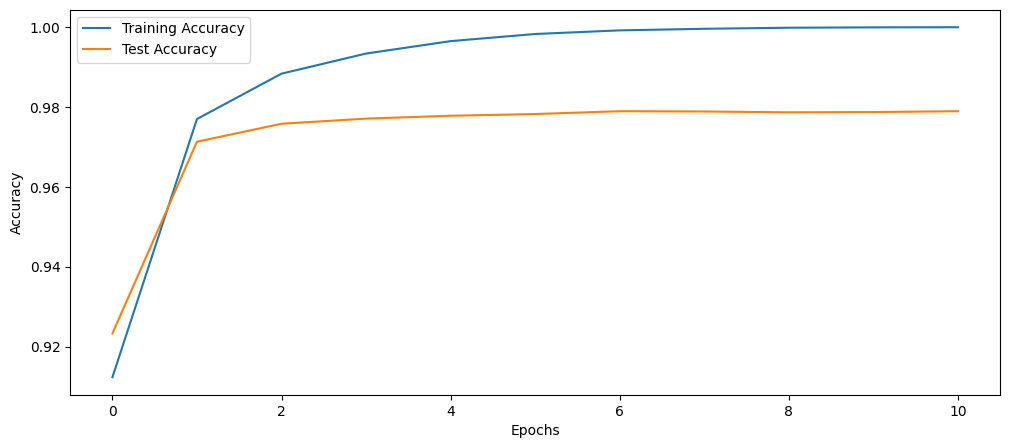

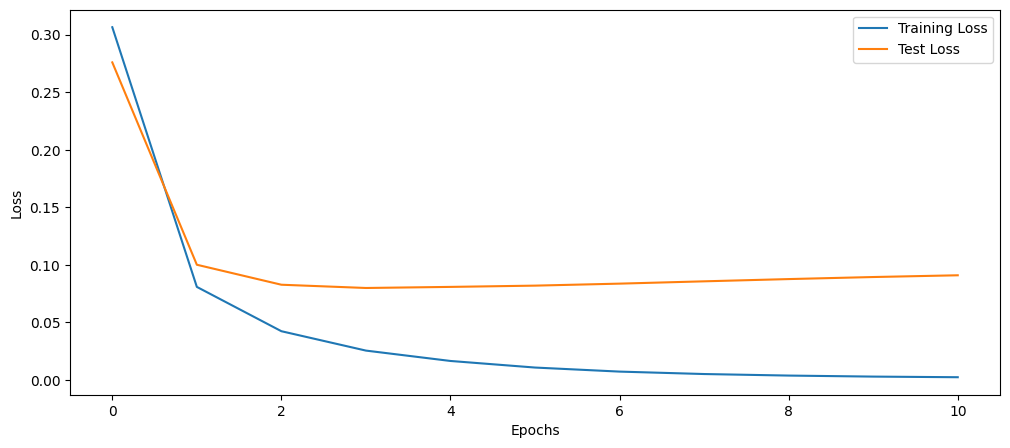

Parameters saved to assets/mnist_params.pkl


In [ ]:
# Train best model on these params
best_config = {
    'layer_widths': [784, 128, 128, 10],
    'activation': 'relu',
    'learning_rate': 0.1,
    'batch_size': 256,
    'epochs': 100
}

params, test_acc, test_loss, learning_curve = train_model(
    x_train, y_train, x_test, y_test, best_config
)

# Print out the best accuracy and learning curve
print(f"Our best model trained on the full training set has an accuracy of {test_acc}%")
print(f"Our best model trained on the full training set has a loss of {test_loss:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(learning_curve['train_acc'], label='Training Accuracy')
plt.plot(learning_curve['test_acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(learning_curve['train_loss'], label='Training Loss')
plt.plot(learning_curve['test_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

save_params(params, filename='../assets/mnist_params.pkl')

   (b) Study how optimizer hyperparameters (batch size, learning rate) affect convergence speed and final performance, and discuss your observations.


 (c) Identify and visualize misclassified images for your best model, and provide possible explanations.